# Notebook Content

In this notebook, we will finding the best classification model,and then we will try to optimize our data (Feature-Engineering) in order to genereate the best model score.

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostRegressor, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.multiclass import OneVsRestClassifier
import pickle
import warnings 
warnings.filterwarnings("ignore")

# Read data from SQL

In [2]:
crime_connection= sql.connect('Crime_df.db')

In [3]:
df_crime = pd.read_sql('SELECT * FROM Crime_df', crime_connection)

In [4]:
df_crime

,index,Agency_Type,State,Year,Crime_Type,Victim_Gender,Victim_Age,Perpetrator_Gender,Perpetrator_Age,Relationship,Weapon,Relationship_classify
0,47,Sheriff,Alabama,1980,Murder or Manslaughter,Male,58,Male,43,Neighbor,Rifle,kinship
1,48,Sheriff,Alabama,1980,Murder or Manslaughter,Male,43,Female,38,Husband,Shotgun,kinship
2,49,Sheriff,Alabama,1980,Murder or Manslaughter,Male,26,Male,66,Acquaintance,Handgun,Acquaintance
3,50,Sheriff,Alabama,1980,Murder or Manslaughter,Male,17,Male,40,Stranger,Handgun,Strangers
4,51,Sheriff,Alabama,1980,Murder or Manslaughter,Male,24,Female,23,Husband,Handgun,kinship
...,...,...,...,...,...,...,...,...,...,...,...,...
284624,638358,Municipal Police,Wisconsin,2014,Murder or Manslaughter,Female,52,Female,51,Sister,Blunt Object,kinship
284625,638359,Municipal Police,Wisconsin,2014,Murder or Manslaughter,Female,23,Female,20,Acquaintance,Handgun,Acquaintance
284626,638361,Municipal Police,Wisconsin,2014,Murder or Manslaughter,Male,24,Male,42,Stranger,Handgun,Strangers
284627,638362,Municipal Police,Wisconsin,2014,Murder or Manslaughter,Female,24,Male,30,Girlfriend,Firearm,kinship


# Drop Index Column 

In [5]:
df_crime.drop('index', axis=1, inplace = True)

# Explore Data

In [6]:
df_crime.State.value_counts()

California        43926
Texas             35180
New York          14633
Michigan          12696
Georgia           12473
Pennsylvania      12078
North Carolina    11571
Illinois          11356
Ohio              10371
Louisiana         10039
Tennessee          9490
Florida            9333
Virginia           9142
South Carolina     8957
New Jersey         7362
Arizona            7253
Maryland           7118
Missouri           6762
Alabama            6649
Oklahoma           6562
Indiana            5873
Washington         5170
Arkansas           4670
Mississippi        4555
Colorado           4020
Kentucky           3843
Wisconsin          3547
Name: State, dtype: int64

In [7]:
df_crime.groupby('State')[['Year']].count().sort_values('Year', ascending= False).reset_index().head()

,State,Year
0,California,43926
1,Texas,35180
2,New York,14633
3,Michigan,12696
4,Georgia,12473


In [8]:
df=df_crime.groupby(['State','Weapon'])[['Year']].count().reset_index()

In [9]:
df.rename(columns= {'Year' : 'State_Weapon_Count'}, inplace = True)

In [10]:
df_crime = (pd.merge(df_crime, df, on=['State', 'Weapon']))

In [11]:
st_weap_count=df_crime['State_Weapon_Count']
df_crime.drop(['State_Weapon_Count'], axis=1, inplace=True)

In [12]:
df2=df_crime.groupby(['State', 'Year'])[['Weapon']].count().reset_index().sort_values('Weapon',ascending=False)

In [13]:
df2.rename(columns= {'Weapon' : 'Number_of_Crimes'}, inplace = True)

In [14]:
df_crime = (pd.merge(df_crime, df2, on=['State', 'Year']))

In [15]:
Number_of_Crimes=df_crime['Number_of_Crimes']
df_crime.drop(['Number_of_Crimes'], axis=1, inplace=True)

In [16]:
df_crime.shape

(284629, 11)

# Clssify Gender Methods

In [17]:
def classify_vic_gen(Victim_Gender):
        if (Victim_Gender == 'Female'):
            return 1
        else:
            return 0

In [18]:
def classify_pre_gen(Perpetrator_Gender):
        if (Perpetrator_Gender == 'Female'):
            return 1
        else:
            return 0

In [19]:
# call the method
df_crime['prep_Gender']= df_crime.Perpetrator_Gender.apply(classify_pre_gen)

In [20]:
# call the method
df_crime['vic_Gender']= df_crime.Victim_Gender.apply(classify_vic_gen)

In [21]:
df_crime.drop(['Perpetrator_Gender','Victim_Gender'],axis=1,inplace=True)

In [22]:
df_crime

,Agency_Type,State,Year,Crime_Type,Victim_Age,Perpetrator_Age,Relationship,Weapon,Relationship_classify,prep_Gender,vic_Gender
0,Sheriff,Alabama,1980,Murder or Manslaughter,58,43,Neighbor,Rifle,kinship,0,0
1,Sheriff,Alabama,1980,Murder or Manslaughter,46,22,Father,Rifle,kinship,0,0
2,Municipal Police,Alabama,1980,Murder or Manslaughter,28,32,Acquaintance,Rifle,Acquaintance,0,0
3,Municipal Police,Alabama,1980,Murder or Manslaughter,53,69,Acquaintance,Rifle,Acquaintance,0,0
4,Municipal Police,Alabama,1980,Murder or Manslaughter,40,34,Husband,Rifle,kinship,0,0
...,...,...,...,...,...,...,...,...,...,...,...
284624,Municipal Police,Wisconsin,2014,Murder or Manslaughter,24,35,Stranger,Firearm,Strangers,0,0
284625,Municipal Police,Wisconsin,2014,Murder or Manslaughter,5,29,Stranger,Firearm,Strangers,0,1
284626,Municipal Police,Wisconsin,2014,Murder or Manslaughter,24,30,Girlfriend,Firearm,kinship,0,1
284627,Sheriff,Wisconsin,2014,Murder or Manslaughter,15,32,Acquaintance,Drugs,Acquaintance,0,1


# Pairplot to Explore Data

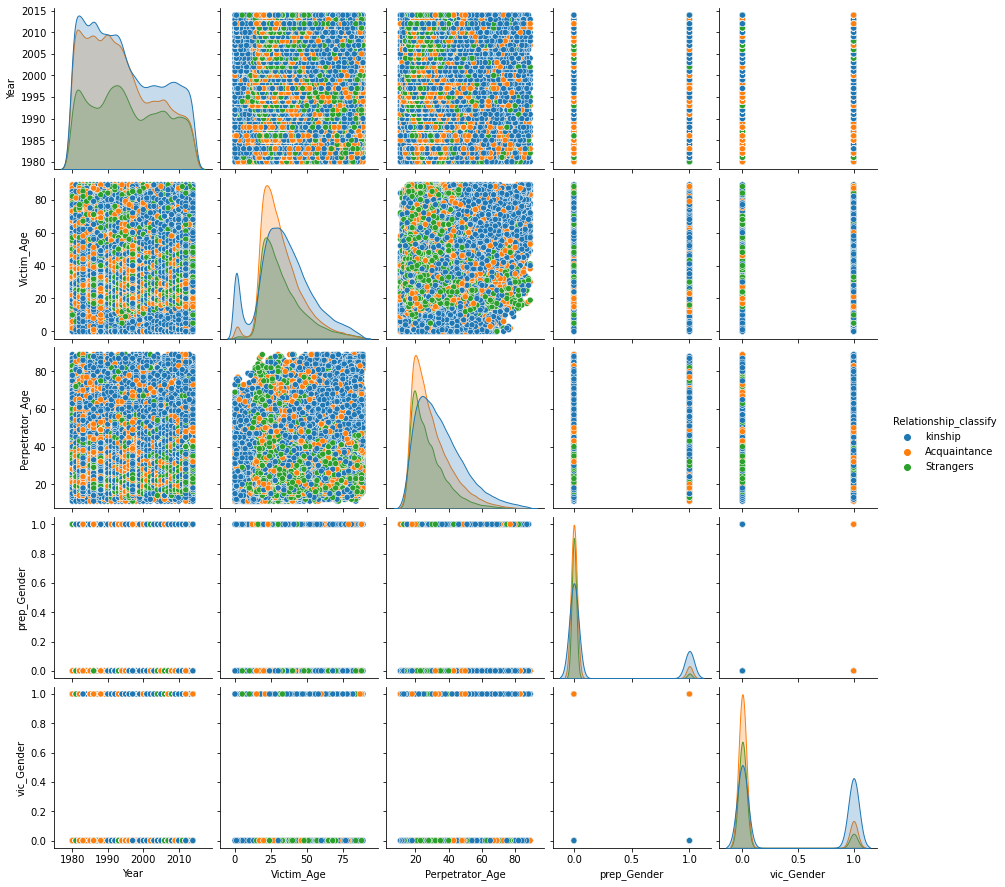

In [23]:
sns.pairplot(df_crime, hue='Relationship_classify');
plt.savefig('pairplot.png')

As we see there is high overlaping between year and relationship, and the data distribution is equally in all types.

# Box plot  for Some Columns

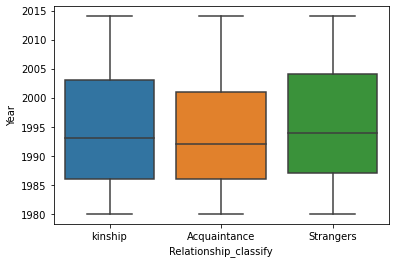

In [24]:
sns.boxplot(x='Relationship_classify', y='Year', data=df_crime);

As shown, the distribution is similar in all types.

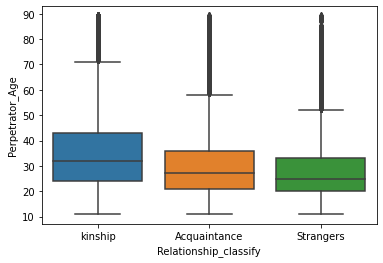

In [25]:
sns.boxplot(x='Relationship_classify', y='Perpetrator_Age', data=df_crime);

As shown, the distribution is similar in all types.

# Convert to Dummy Variables

In [26]:
df_temp = df_crime.copy()

In [27]:
dummies = pd.get_dummies(df_temp[['Agency_Type', 'State', 'Crime_Type','Relationship', 'Weapon']], drop_first=True)
df_temp = pd.concat([df_temp.drop(['Agency_Type', 'State', 'Crime_Type','Relationship', 'Weapon'],axis=1), dummies],axis=1)

In [28]:
df_temp1 = df_crime.copy()

dummies1=pd.get_dummies(df_temp1['Relationship_classify'])
df_temp1 = pd.concat([df_temp1.drop(['Relationship_classify'],axis=1), dummies1],axis=1)

ys= df_temp1[['Acquaintance' ,'Strangers', 'kinship']]

In [29]:
df_temp.shape

(284629, 79)

In [30]:
df_temp.corr()

,Year,Victim_Age,Perpetrator_Age,prep_Gender,vic_Gender,Agency_Type_Municipal Police,Agency_Type_Regional Police,Agency_Type_Sheriff,Agency_Type_Special Police,Agency_Type_State Police,...,Weapon_Fire,Weapon_Firearm,Weapon_Gun,Weapon_Handgun,Weapon_Knife,Weapon_Poison,Weapon_Rifle,Weapon_Shotgun,Weapon_Strangulation,Weapon_Suffocation
Year,1.000000,0.014082,0.022670,-0.055096,0.041367,-0.028294,0.006359,0.016498,-0.008475,0.000416,...,-0.006765,0.113665,0.026087,0.012927,-0.032906,0.002315,-0.047146,-0.072693,-0.004557,0.022415
Victim_Age,0.014082,1.000000,0.376814,0.007756,0.063444,-0.070317,0.006333,0.071164,-0.001367,0.027519,...,-0.009028,-0.010135,-0.002189,-0.055621,0.071880,0.004436,0.007758,0.019255,0.020847,-0.047490
Perpetrator_Age,0.022670,0.376814,1.000000,0.043012,0.174537,-0.091684,0.007774,0.087045,0.002159,0.036316,...,0.000634,-0.007622,-0.003326,0.003130,-0.016305,0.016116,0.017739,0.053068,-0.001766,-0.001020
prep_Gender,-0.055096,0.007756,0.043012,1.000000,-0.061456,-0.004087,0.000328,0.007389,0.005328,-0.005712,...,0.042488,-0.028524,-0.005609,-0.073316,0.117750,0.024209,-0.030050,-0.041019,-0.010274,0.064806
vic_Gender,0.041367,0.063444,0.174537,-0.061456,1.000000,-0.055507,0.006246,0.040055,0.004243,0.031424,...,0.044434,-0.013731,-0.003773,-0.106339,0.004164,0.015919,-0.009098,-0.006235,0.104064,0.060526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Weapon_Poison,0.002315,0.004436,0.016116,0.024209,0.015919,-0.010300,0.004693,0.002397,0.033446,0.008029,...,-0.003010,-0.005956,-0.001446,-0.030206,-0.014863,1.000000,-0.007024,-0.008369,-0.003304,-0.002641
Weapon_Rifle,-0.047146,0.007758,0.017739,-0.030050,-0.009098,-0.104229,0.000346,0.101529,-0.006193,0.041963,...,-0.022518,-0.044558,-0.010814,-0.225980,-0.111195,-0.007024,1.000000,-0.062612,-0.024718,-0.019754
Weapon_Shotgun,-0.072693,0.019255,0.053068,-0.041019,-0.006235,-0.104925,0.003806,0.101840,-0.008374,0.043966,...,-0.026828,-0.053089,-0.012885,-0.269241,-0.132482,-0.008369,-0.062612,1.000000,-0.029449,-0.023536
Weapon_Strangulation,-0.004557,0.020847,-0.001766,-0.010274,0.104064,0.000951,0.000760,-0.000787,-0.000905,0.000663,...,-0.010591,-0.020958,-0.005086,-0.106289,-0.052300,-0.003304,-0.024718,-0.029449,1.000000,-0.009291


# Save to Pickle

In [31]:
df_temp.to_pickle("dummy.pkl")

# Split Data

### Split the Features And Target

In [32]:
X=df_temp.drop(['Relationship_classify'],axis=1)
y=df_temp['Relationship_classify']

### Split Train-Validation-Test

In [33]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.05,random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=.05,random_state=42)

### Explore Each Dateset

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256877 entries, 193930 to 173603
Data columns (total 78 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   Year                               256877 non-null  int64
 1   Victim_Age                         256877 non-null  int64
 2   Perpetrator_Age                    256877 non-null  int64
 3   prep_Gender                        256877 non-null  int64
 4   vic_Gender                         256877 non-null  int64
 5   Agency_Type_Municipal Police       256877 non-null  uint8
 6   Agency_Type_Regional Police        256877 non-null  uint8
 7   Agency_Type_Sheriff                256877 non-null  uint8
 8   Agency_Type_Special Police         256877 non-null  uint8
 9   Agency_Type_State Police           256877 non-null  uint8
 10  Agency_Type_Tribal Police          256877 non-null  uint8
 11  State_Arizona                      256877 non-null  uint8
 1

In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14232 entries, 60540 to 101937
Data columns (total 78 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Year                               14232 non-null  int64
 1   Victim_Age                         14232 non-null  int64
 2   Perpetrator_Age                    14232 non-null  int64
 3   prep_Gender                        14232 non-null  int64
 4   vic_Gender                         14232 non-null  int64
 5   Agency_Type_Municipal Police       14232 non-null  uint8
 6   Agency_Type_Regional Police        14232 non-null  uint8
 7   Agency_Type_Sheriff                14232 non-null  uint8
 8   Agency_Type_Special Police         14232 non-null  uint8
 9   Agency_Type_State Police           14232 non-null  uint8
 10  Agency_Type_Tribal Police          14232 non-null  uint8
 11  State_Arizona                      14232 non-null  uint8
 12  State_Arkansa

In [36]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13520 entries, 55603 to 214129
Data columns (total 78 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Year                               13520 non-null  int64
 1   Victim_Age                         13520 non-null  int64
 2   Perpetrator_Age                    13520 non-null  int64
 3   prep_Gender                        13520 non-null  int64
 4   vic_Gender                         13520 non-null  int64
 5   Agency_Type_Municipal Police       13520 non-null  uint8
 6   Agency_Type_Regional Police        13520 non-null  uint8
 7   Agency_Type_Sheriff                13520 non-null  uint8
 8   Agency_Type_Special Police         13520 non-null  uint8
 9   Agency_Type_State Police           13520 non-null  uint8
 10  Agency_Type_Tribal Police          13520 non-null  uint8
 11  State_Arizona                      13520 non-null  uint8
 12  State_Arkansa

# Calculate Scores Method

In [37]:
def cal_score(X_train_f, X_val_f, y_train_f, y_val_f):
    """
    This method will be called to fit the training and validation sets with score for all models.
    """
    models = [LogisticRegression(C=1000),DecisionTreeClassifier(max_depth=15),
                  RandomForestClassifier(max_depth=2,random_state=0), BernoulliNB(),
                  MultinomialNB(),GaussianNB(),
              GradientBoostingClassifier(n_estimators=70, max_depth=3, learning_rate=.02)]
    models_names= ['LogisticRegression' ,'DecisionTreeClassifier' ,
              'RandomForestClassifier' , 'BernoulliNB' ,
              'MultinomialNB' ,'GaussianNB','GradientBoostingClassifier']
    i=0
    for model in models:
        mod= OneVsRestClassifier(model).fit(X_train_f, y_train_f)
        t_score=mod.score(X_train_f, y_train_f)
        v_score=mod.score(X_val_f, y_val_f)
        print('Training score in {0} {1:.9f}'.format(models_names[i],t_score))
        print('Validation score in {0} {1:.9f}'.format(models_names[i],v_score))
        print('------------------------------------------------------')
        print()
        i+=1

In [42]:
def cal_score_grid(X_train_f, X_val_f, y_train_f, y_val_f):
    """
    This method will be called to fit the training and validation sets with score for all models.
    """
    models = [LogisticRegression(C=1000),DecisionTreeClassifier(max_depth=15),
                  RandomForestClassifier(max_depth=2,random_state=0), BernoulliNB(),
              GaussianNB(var_smoothing=1.2328467394420635e-09),
              GradientBoostingClassifier(n_estimators=70, max_depth=3, learning_rate=.02)]
    models_names= ['LogisticRegression' ,'DecisionTreeClassifier' ,
              'RandomForestClassifier' , 'BernoulliNB' ,
              'GaussianNB','GradientBoostingClassifier']
    i=0
    for model in models:
        mod= OneVsRestClassifier(model).fit(X_train_f, y_train_f)
        t_score=mod.score(X_train_f, y_train_f)
        v_score=mod.score(X_val_f, y_val_f)
        print('Training score in {0} {1:.9f}'.format(models_names[i],t_score))
        print('Validation score in {0} {1:.9f}'.format(models_names[i],v_score))
        print('------------------------------------------------------')
        print()
        i+=1

# Training and Validation Scores Before Feature Engineering

In [38]:
# call the method to calculate scores
cal_score(X_train, X_val, y_train, y_val)

Training score in LogisticRegression 0.930363559
Validation score in LogisticRegression 0.930843195
------------------------------------------------------

Training score in DecisionTreeClassifier 0.990267716
Validation score in DecisionTreeClassifier 0.989275148
------------------------------------------------------

Training score in RandomForestClassifier 0.817531348
Validation score in RandomForestClassifier 0.816937870
------------------------------------------------------

Training score in BernoulliNB 0.959357981
Validation score in BernoulliNB 0.960059172
------------------------------------------------------

Training score in MultinomialNB 0.906577856
Validation score in MultinomialNB 0.907100592
------------------------------------------------------

Training score in GaussianNB 0.998606337
Validation score in GaussianNB 0.998668639
------------------------------------------------------

Training score in GradientBoostingClassifier 0.867345072
Validation score in GradientBoo

**As we see, there is no overfitting in all models, and GaussianNB model gives us the highest score, so we will choose it, and now we will try to find the best model's parameter by using GridSearch function.**

# GridSearch 

In [39]:
# fit the model's parameter
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [40]:
# using gridsearch function in gaussian mmodel
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=5, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
GaussianNB(var_smoothing=1.2328467394420635e-09)


As we see, the best value of var_smooth in Gaussian model is **(1.2329e-09)**

# Feature Engineeering

### First Iteration 

In this iteration, we will add the difference in age between **victim** and **perpetrator**

In [43]:
X_train_1 = X_train.copy()
X_val_1 = X_val.copy()

X_train_1['Diff_Between_Vic_Per']= abs(X_train_1['Perpetrator_Age']- X_train_1['Victim_Age'])


X_val_1['Diff_Between_Vic_Per']= abs(X_val_1['Perpetrator_Age']- X_val_1['Victim_Age'])


cal_score_grid(X_train_1, X_val_1, y_train, y_val) 

Training score in LogisticRegression 0.891087953
Validation score in LogisticRegression 0.890828402
------------------------------------------------------

Training score in DecisionTreeClassifier 0.990267716
Validation score in DecisionTreeClassifier 0.989275148
------------------------------------------------------

Training score in RandomForestClassifier 0.903743815
Validation score in RandomForestClassifier 0.904955621
------------------------------------------------------

Training score in BernoulliNB 0.959159442
Validation score in BernoulliNB 0.959985207
------------------------------------------------------

Training score in GaussianNB 0.998516800
Validation score in GaussianNB 0.998668639
------------------------------------------------------

Training score in GradientBoostingClassifier 0.867345072
Validation score in GradientBoostingClassifier 0.866124260
------------------------------------------------------



As seen, the scores almost the same, but it decreased in the __LogisticRegression, and RandomForest model__, so we will skip this iteration.

### Second Iteration 

In this iteration, We'll do the same as iteration before, with deleting __Victim_Age__, and  __Perpetrator_Age__ columns.

In [44]:
X_train_2 = X_train.copy()
X_val_2 = X_val.copy()

X_train_2['Diff_Between_Vic_Per']= abs(X_train_2['Perpetrator_Age']- X_train_2['Victim_Age'])
X_train_2.drop(['Victim_Age', 'Perpetrator_Age'], axis = 1, inplace = True)


X_val_2['Diff_Between_Vic_Per']= abs(X_val_2['Perpetrator_Age']- X_val_2['Victim_Age'])
X_val_2.drop(['Victim_Age', 'Perpetrator_Age'], axis = 1, inplace = True)


cal_score_grid(X_train_2, X_val_2, y_train, y_val)

Training score in LogisticRegression 0.935895390
Validation score in LogisticRegression 0.937426036
------------------------------------------------------

Training score in DecisionTreeClassifier 0.990267716
Validation score in DecisionTreeClassifier 0.989275148
------------------------------------------------------

Training score in RandomForestClassifier 0.893470416
Validation score in RandomForestClassifier 0.894156805
------------------------------------------------------

Training score in BernoulliNB 0.957645099
Validation score in BernoulliNB 0.958949704
------------------------------------------------------

Training score in GaussianNB 0.998777625
Validation score in GaussianNB 0.998890533
------------------------------------------------------

Training score in GradientBoostingClassifier 0.867345072
Validation score in GradientBoostingClassifier 0.866124260
------------------------------------------------------



As seen, the scores increased in some models, and the __gaussian model__ is the highest one with training score __0.99877__ and validation score __0.99889__. Also there is no overvitting, so we will approve it! 

In [45]:
# Approve the change
X_train=X_train_2
X_val=X_val_2
X_test['Diff_Between_Vic_Per']= abs(X_test['Perpetrator_Age']- X_test['Victim_Age'])
X_test.drop(['Victim_Age', 'Perpetrator_Age'], axis = 1, inplace = True)

### Third Iteration

In this iteration, we will add column that count the number of each weapon used in each state.

In [46]:
X_train_3 = X_train.copy()
X_val_3 = X_val.copy()

X_train_3['State_Weapon_Count']= st_weap_count


X_val_3['State_Weapon_Count']= st_weap_count

cal_score_grid(X_train_3, X_val_3, y_train, y_val) 

Training score in LogisticRegression 0.927700806
Validation score in LogisticRegression 0.926775148
------------------------------------------------------

Training score in DecisionTreeClassifier 0.990267716
Validation score in DecisionTreeClassifier 0.989275148
------------------------------------------------------

Training score in RandomForestClassifier 0.907278581
Validation score in RandomForestClassifier 0.907470414
------------------------------------------------------

Training score in BernoulliNB 0.957645099
Validation score in BernoulliNB 0.958949704
------------------------------------------------------

Training score in GaussianNB 0.880654944
Validation score in GaussianNB 0.878624260
------------------------------------------------------

Training score in GradientBoostingClassifier 0.867345072
Validation score in GradientBoostingClassifier 0.866124260
------------------------------------------------------



As we see, most of scores is decreased, so we will skip this iteration.

### Forth Iteration

In this iteration, we will add column that count the number of crimes in each state.

In [47]:
X_train_4 = X_train.copy()
X_val_4 = X_val.copy()


X_train_4['Number_of_Crimes']= Number_of_Crimes


X_val_4['Number_of_Crimes']= Number_of_Crimes


cal_score_grid(X_train_4, X_val_4, y_train, y_val)

Training score in LogisticRegression 0.933859396
Validation score in LogisticRegression 0.934985207
------------------------------------------------------

Training score in DecisionTreeClassifier 0.990267716
Validation score in DecisionTreeClassifier 0.989275148
------------------------------------------------------

Training score in RandomForestClassifier 0.895658233
Validation score in RandomForestClassifier 0.895340237
------------------------------------------------------

Training score in BernoulliNB 0.957645099
Validation score in BernoulliNB 0.958949704
------------------------------------------------------

Training score in GaussianNB 0.996792239
Validation score in GaussianNB 0.997115385
------------------------------------------------------

Training score in GradientBoostingClassifier 0.867345072
Validation score in GradientBoostingClassifier 0.866124260
------------------------------------------------------



As we see, the __LogisticRegression__ score increased, but most of scores is decreased, so we will skip this iteration.

# Final Shape

In [48]:
X_train.shape

(256877, 77)

# Combine both train and validation sets 

In [49]:
X_train_val = pd.concat([X_train,X_val])

In [50]:
y_train_val = pd.concat([y_train,y_val])

# Test score on Selected Model

In [51]:
GNB_model=OneVsRestClassifier(GaussianNB(var_smoothing=1.2328467394420635e-09)).fit(X_train_val,y_train_val)
y_pred = GNB_model.predict(X_test)
print('Gaussian training score: ',GNB_model.score(X_train_val,y_train_val))
print('Gaussian testing score: ',GNB_model.score(X_test,y_test))

Gaussian training score:  0.9987610809291523
Gaussian testing score:  0.9983136593591906


# Error on Selected Model

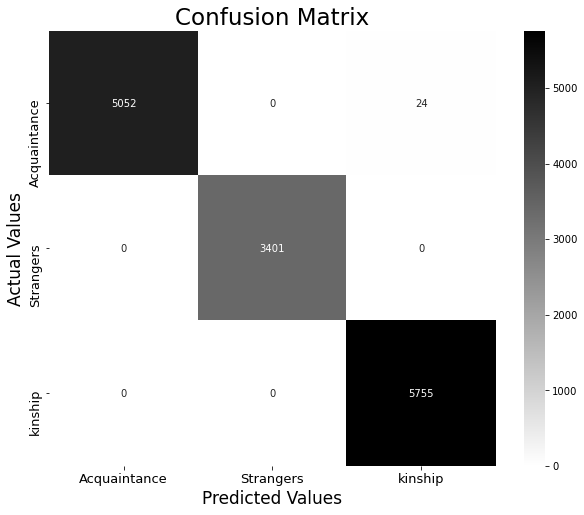

In [59]:
# confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(conf_mat, cmap='binary',annot=True, fmt='.5g', ax=ax);
ax.set_xlabel('Predicted Values', fontsize=17, color='Black');
ax.set_ylabel('Actual Values',fontsize=17, color='Black'); 
ax.set_title('Confusion Matrix', color='Black', fontsize=23); 
ax.xaxis.set_ticklabels(['Acquaintance', 'Strangers', 'kinship'],fontsize=13, color='Black');
ax.yaxis.set_ticklabels(['Acquaintance', 'Strangers', 'kinship'],fontsize=13,color='Black');
plt.savefig('confusionMatrix.png')

As seen, the All relationships types are correctly classified except __Acquaintance Relationship__ , 23 of them are categorized as __Kinship Relationship__.

# Calculate Accuracy and Error Scores

In [53]:
def ModelScores(actual, preds):
    
    print(" Accuracy score: ", metrics.accuracy_score(actual, preds))
    print(" Error Rate: ", 1-(metrics.accuracy_score(actual, preds)))
ModelScores(y_test, y_pred)    

 Accuracy score:  0.9983136593591906
 Error Rate:  0.001686340640809414


As shown, the **Error Rate** is very low which is equal to **(0.001686)**, and the __Acuracy Score__ is equal to  __(0.99831)__. which is good!


# Classification Report

In [54]:
Cr = metrics.classification_report(y_test, y_pred)
print( Cr)

print(" Training Score: ", GNB_model.score(X_train, y_train))
print(" Test Score: ", GNB_model.score(X_test, y_test))

              precision    recall  f1-score   support

Acquaintance       1.00      1.00      1.00      5076
   Strangers       1.00      1.00      1.00      3401
     kinship       1.00      1.00      1.00      5755

    accuracy                           1.00     14232
   macro avg       1.00      1.00      1.00     14232
weighted avg       1.00      1.00      1.00     14232

 Training Score:  0.9987542676066755
 Test Score:  0.9983136593591906


As seen in previous report, all metrics values is **1**. And this does not contradict our previous results.

# ROC 

In [55]:
print("ROC AUC score = ", metrics.roc_auc_score(y_test, GNB_model.predict_proba(X_test),multi_class="ovr"))

ROC AUC score =  0.9996657622586608


As shown, the __ROC AUC score__ is equal __(0.99967)__, which is almost equal 1

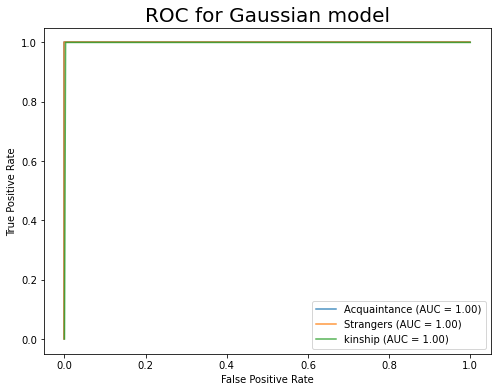

In [56]:
labels= ['Acquaintance' ,'Strangers', 'kinship']


Xs_train,Xs_test,ys_train,ys_test=train_test_split(X,ys,test_size=.05,random_state=42)


labelPlots ={}
c=0
plt.figure(figsize=(8,6))
for i in range(3):
    gsb = GaussianNB()
    gsb.fit(Xs_train, ys_train.iloc[:,i])
    ax = plt.gca()
    labelPlots[i]= metrics.plot_roc_curve(gsb, Xs_test, ys_test.iloc[:,i], name= (labels[c]), ax=ax, alpha=0.8)
    c+=1
# plt.xticks(color='White')
# plt.yticks(color='White')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Gaussian model', fontsize=20)
plt.savefig('Roc gausiian.png');
plt.show();

As seen, the score is **1** in all types, which is approaved our previous results.

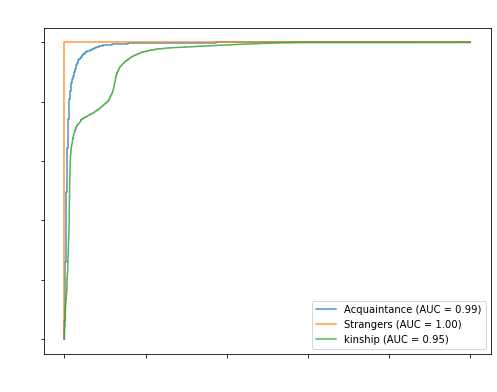

In [57]:
labelPlots ={}
c=0
plt.figure(figsize=(8,6))
for i in range(3):
    logis = LogisticRegression()
    logis.fit(Xs_train, ys_train.iloc[:,i])
    ax = plt.gca()
    labelPlots[i]= metrics.plot_roc_curve(logis, Xs_test, ys_test.iloc[:,i], name= (labels[c]), ax=ax, alpha=0.8)
    c+=1
plt.xticks(color='White')
plt.yticks(color='White')
plt.xlabel('False Positive Rate', color='White')
plt.ylabel('True Positive Rate', color='White')
plt.title('ROC for Logistic Regression model', fontsize=20, color='White')    
plt.savefig('Roc Logistic.png');
plt.show();

The score is lower than **Gaussian model**, but still is high.